In [ ]:
https://aifreeblog.herokuapp.com/posts/64/Data_Analytics_in_Practice_Titanic/
https://medium.com/%E6%95%B8%E6%93%9A%E4%B8%8D%E6%AD%A2-not-only-data/pandas-%E5%BF%AB%E9%80%9F%E7%9E%AD%E8%A7%A3-pivot-table-%E8%88%87%E6%87%89%E7%94%A8-21e4c37b9216

# 安裝需要套件

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 4.1 MB/s 


# 讀取資料

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix,recall_score,classification_report,ConfusionMatrixDisplay,accuracy_score
import category_encoders as ce #Encoder 用
from sklearn.metrics import confusion_matrix, accuracy_score
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#kaggle的資料讀取
#train=pd.read_csv('../input/titanic/train.csv')
#test=pd.read_csv('../input/titanic/test.csv')


#google drive上的資料讀取
path='/content/drive/MyDrive/Colab Notebooks/Titanic/'
train=pd.read_csv(path+'train.csv')
test=pd.read_csv(path+'test.csv')


In [ ]:
# 定義用來統計欄位缺漏值總數的函數
def Missing_Counts( Data ) : 
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量 
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True ) 
    
    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

In [ ]:
print( 'train :' )
display( Missing_Counts(train) )

print( 'test :' )
display( Missing_Counts(test) )

train :


,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


test :


,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.24
1,Age,86,20.57
2,Cabin,327,78.23


train data: Age、Cabin、Embarked有缺失值

test data: Age,Fare,Cabin 有缺失值

In [ ]:
#先合併,一起統一處理缺失值
df=pd.concat([train,test], ignore_index=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 探索資料

## 整體資料

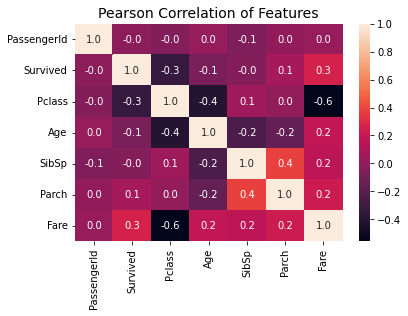

In [ ]:
sns.heatmap(df.corr(),annot=True,fmt=".1f")
plt.title('Pearson Correlation of Features', y=1.05, size=14)
plt.show()

類別欄位因還沒有處理,所以只有數值的欄位。

觀察到好像互相沒有什麼密切的相關性。

接下來就個別欄位來觀察生存率

In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


平均生還率38%,登船年齡最小不足一歲,最大為80歲

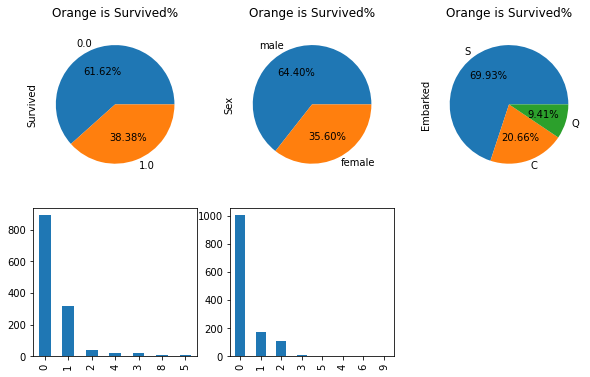

In [ ]:
plt.figure(figsize=(10,6))

i=0
for j in ['Survived','Sex','Embarked','SibSp','Parch']:
    i+=1
    if i<4:
        plt.subplot(2, 3, i)
        df[j].value_counts().plot(kind='pie',autopct='%1.2f%%')
        plt.title('Orange is Survived%', y=1.05, size=12)
    else:
        plt.subplot(2, 3, i)
        df[j].value_counts().plot(kind='bar')

plt.show()

由圖得知:
1. 平均生還率38%
2. 男女佔比分別約為64%和36%
3. 由S(Sounthampton)登船佔約7成
4. 大部份乘客都沒有與手足及配偶(SibSp)、雙親和子女(Parch)同行

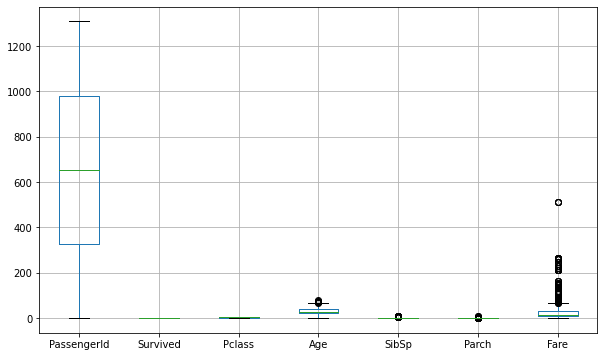

In [ ]:
plt.figure(figsize=(10,6))
df.boxplot()
plt.show()
#Fare有明顯離群值,後續查看是否需要處理

## 艙等Pclass vs 生存率

{'Pclass_1': 0.42105263157894735, 'Pclass_2': 0.3140794223826715, 'Pclass_3': 0.16784203102961917}



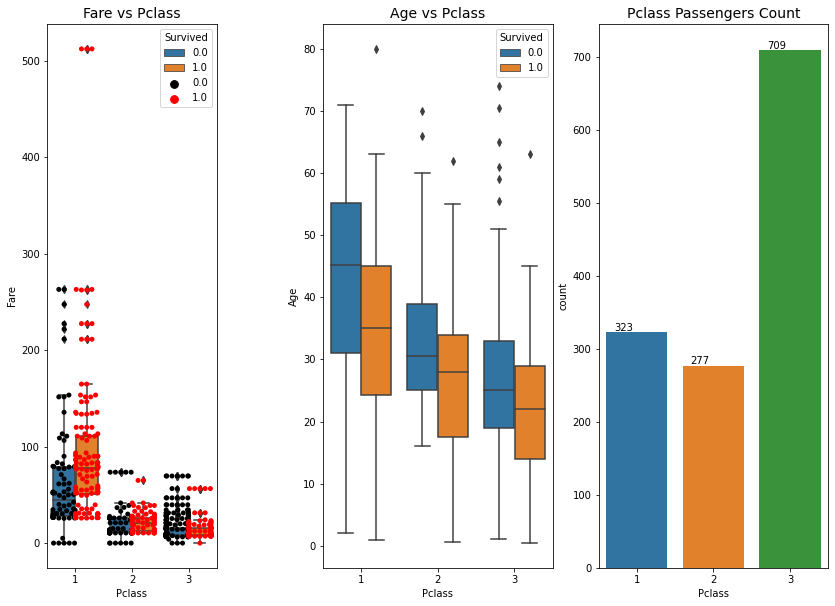

Survived,0.0,1.0,All
Pclass,,,
1,64.684008,95.608029,84.154687
2,19.412328,22.055700,20.662183
3,13.669364,13.694887,13.675550
All,22.117887,48.395408,32.204208


In [ ]:
#艙等/艙等乘客人數 佔比
pclass_survived={}
for i,j in enumerate(["Pclass_1","Pclass_2","Pclass_3"]):
    pclass_survived[j]=(df[(df['Pclass']==i+1) & (df['Survived']==1)].PassengerId.count()
                 /df[df['Pclass']==i+1].PassengerId.count())

print(pclass_survived)
print()


plt.figure(figsize=(14,10))
ax=plt.subplot(1,4, 1)
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=df)
sns.swarmplot(x='Pclass', y='Fare', hue='Survived', data=df, dodge=True,palette=sns.color_palette(['black', 'red']))
plt.title('Fare vs Pclass', y=1, size=14)


ax=plt.subplot(1, 3, 2)
sns.boxplot(x='Pclass', y='Age', hue='Survived', data=df)
plt.title('Age vs Pclass', y=1, size=14)


ax=plt.subplot(1, 3, 3)
sns.countplot(x='Pclass', data=df)
plt.title('Pclass Passengers Count', y=1, size=14)


#在圖上顯示數值
for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+1.5) )
plt.show()



print()
pd.crosstab(df['Pclass'],df['Survived'],values=df['Fare'],aggfunc=np.average,margins = True)

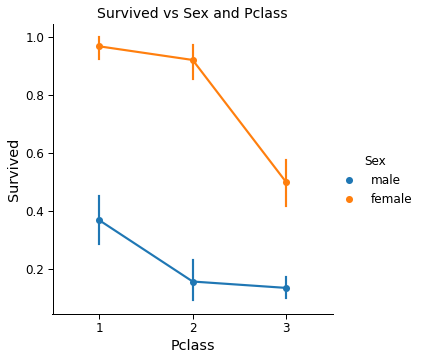

In [ ]:
sns.set_context("paper",font_scale=1.5,rc={'xtick.labelsize': 12,'ytick.labelsize': 12,
'legend.fontsize': 12,'legend.title_fontsize': 12})


ax=sns.factorplot('Pclass','Survived',hue='Sex',data=df,size=5) 
plt.title('Survived vs Sex and Pclass', fontsize= 14)
plt.show()

In [ ]:
df[(df.Pclass==1) & (df.Sex=='female')].Survived.value_counts()

1.0    91
0.0     3
Name: Survived, dtype: int64

購買高票價有較高的生存率,年輕族群傾向購買便宜的Pclass_3

女性且高價票的存活率高達96%，只有三位死亡。
男性且高價票的存活率卻低

## 性別sex  vs 生存率

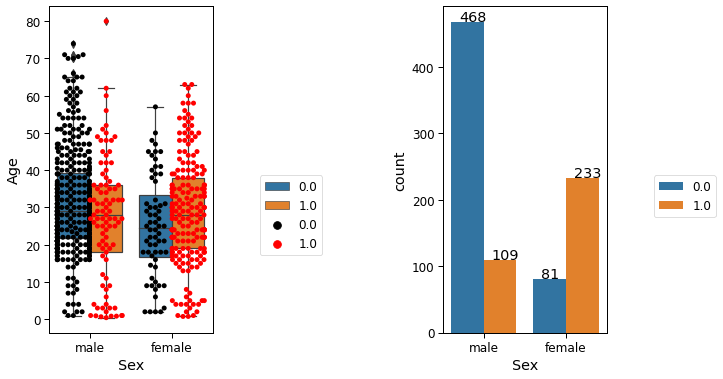


Survived  0.0  1.0  All
Sex                    
female     81  233  314
male      468  109  577
All       549  342  891

          0         1         2
0  0.147541  0.681287  0.352413
1  0.852459  0.318713  0.647587
2  1.000000  1.000000  1.000000


In [ ]:
plt.figure(figsize=(10,6))

ax=plt.subplot(1, 3, 1)
sns.boxplot(x='Sex', y='Age', hue='Survived', data=df)
sns.swarmplot(x='Sex', y='Age', hue='Survived', data=df, dodge=True,
             palette=sns.color_palette(['black', 'red']))
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)


ax=plt.subplot(1, 3, 3)
sns.countplot(x="Sex", hue="Survived", data=df)
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)


for p in ax.patches:ax.annotate( '{:,}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+1.5) )
plt.show()

print()
print(pd.crosstab(df['Sex'],df['Survived'],margins = True))

print()
crosstable1 = pd.crosstab(df['Sex'],df['Survived'],margins = True)
crossarray1 = np.array(crosstable1)
crossall = np.array(crosstable1.loc['All', :]).reshape(1, -1)
crossprop = crossarray1/crossall
crossprop=pd.DataFrame(crossprop)
print(crossprop)

In [ ]:
df.pivot_table(index=['Sex'], values='Survived', margins=True, aggfunc=['mean', 'count'])

,mean,count
,Survived,Survived
Sex,,
female,0.742038,314
male,0.188908,577
All,0.383838,891


男性生存率遠低於女性,且年紀輕較易存活;女性情況則相反，但沒有十分明顯。

## 票價Fare vs 生存率

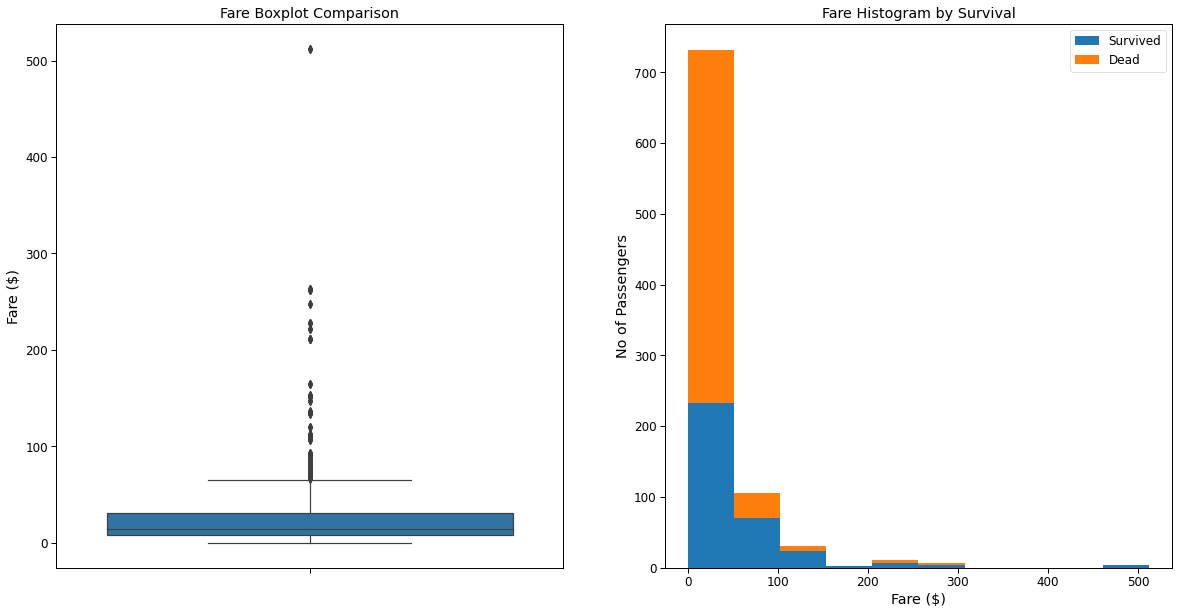

In [ ]:
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1)
sns.boxplot( y='Fare', hue='Survived', data=df)
plt.title('Fare Boxplot Comparison')
plt.ylabel('Fare ($)')


fig.add_subplot(1,2,2)
plt.hist(x = [df[df['Survived']==1]['Fare'], df[df['Survived']==0]['Fare']], stacked=True,label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('No of Passengers')
plt.legend()

plt.show()

In [ ]:
df[(df['Fare']>300)&(~df['Survived'].isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1.0,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1.0,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1.0,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


絕大多數人都是購買低價船票

購買票價超過300,有較高機率存活,

票價超過100以上即為離群值,但因高票價為高生存率之重要特徵,故不作刪除,僅作常態化處理

## 年齡Age vs 生存率

In [ ]:
print('最高齡死亡者:',df['Age'].max(),'Years')
print('最年輕死亡者:',df['Age'].min(),'Years')
print('死亡平均年齡:',df['Age'].mean(),'Years')

最高齡死亡者: 80.0 Years
最年輕死亡者: 0.17 Years
死亡平均年齡: 29.881137667304014 Years


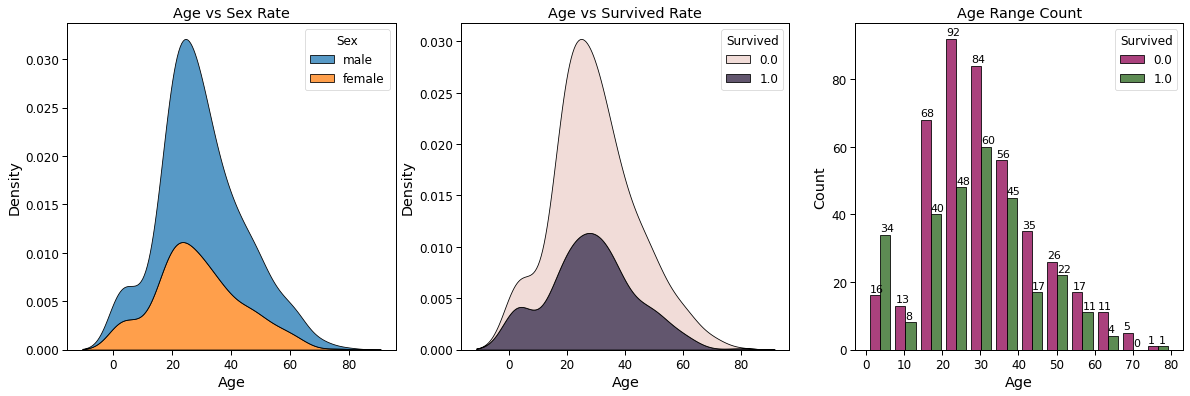

In [ ]:
fig=plt.figure(figsize=(20,6))
ax=fig.add_subplot(1,3,1)
sns.kdeplot(data=df,x='Age', hue="Sex", multiple="stack" )
plt.title("Age vs Sex Rate")

ax=fig.add_subplot(1,3,2)
sns.kdeplot(data=df,x='Age', hue="Survived", multiple="stack" )
plt.title("Age vs Survived Rate")


ax=fig.add_subplot(1,3,3)
sns.histplot(x=df['Age'], shrink=0.8, bins=12, 
             hue=df['Survived'], multiple="dodge",palette='PiYG' )
plt.title("Age Range Count")


for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+1),fontsize=11 )

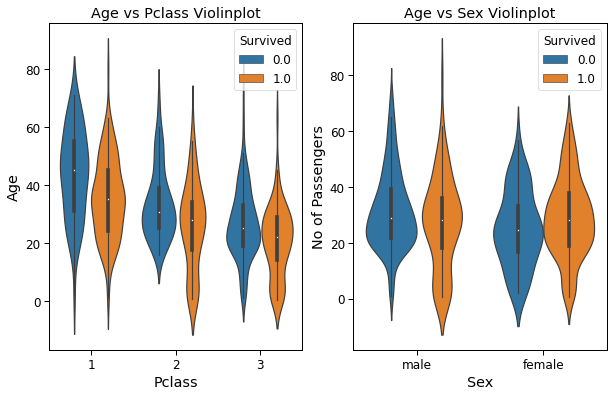

In [ ]:
plt.figure(figsize=(10,6))

ax=plt.subplot(1, 2, 1)
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df)
plt.title('Age vs Pclass Violinplot')


ax=plt.subplot(1, 2, 2)
sns.violinplot(x="Sex", y='Age',hue="Survived", data=df)
plt.title('Age vs Sex Violinplot')
plt.ylabel('No of Passengers')


plt.show()

死亡集中於20~40歲之間,相同的生存人數也是如北

## 登船港口Embarked vs 生存率

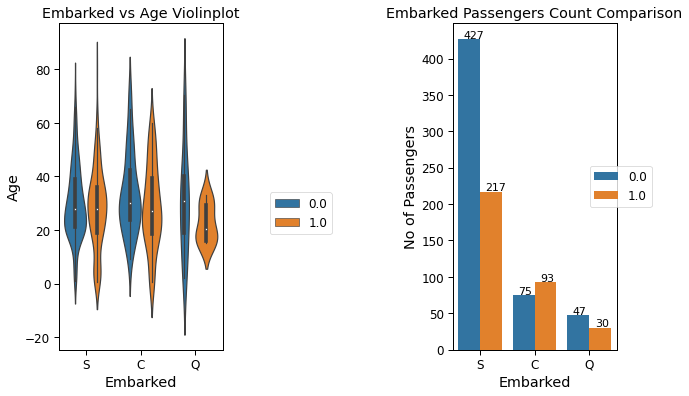

In [ ]:
plt.figure(figsize=(10,6))

ax=plt.subplot(1, 3, 1)
sns.violinplot(x='Embarked', y='Age', hue='Survived', data=df)
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Embarked vs Age Violinplot')


ax=plt.subplot(1, 3, 3)
sns.countplot(x="Embarked", hue="Survived", data=df)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Embarked Passengers Count Comparison')
plt.ylabel('No of Passengers')


for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+1.5),fontsize=11 )


plt.show()

In [ ]:
display(df.pivot_table(index=['Embarked'], values='Survived', margins=True,aggfunc=['mean', 'count']))
display(df.pivot_table(index=['Embarked','Sex'], values='Survived', margins=True, aggfunc=['mean', 'count']))

,mean,count
,Survived,Survived
Embarked,,
C,0.553571,168
Q,0.389610,77
S,0.336957,644
All,0.382452,889


mean    count
                 Survived Survived
Embarked Sex                      
C        female  0.876712       73
         male    0.305263       95
Q        female  0.750000       36
         male    0.073171       41
S        female  0.689655      203
         male    0.174603      441
All              0.382452      889

In [ ]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


港口生存率: C>Q>S

女性不論在哪個港口登船,其生存率都高於男性

可以發現有缺失值981-889=2個，用最多的"S"代入

## 家屬SibSp Parch vs 生存率

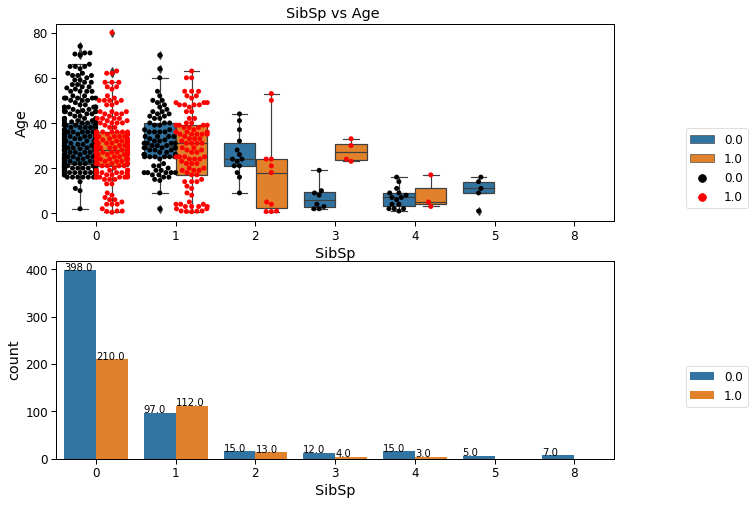

In [ ]:
plt.figure(figsize=(10,8))

ax=plt.subplot(2, 1, 1)
sns.boxplot(x='SibSp',y='Age', hue='Survived', data=df)

sns.swarmplot(x='SibSp', y='Age', hue='Survived', data=df, dodge=True,
             palette=sns.color_palette(['black', 'red']))
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('SibSp vs Age ')


ax=plt.subplot(2, 1, 2)
sns.countplot(x="SibSp", hue="Survived", data=df)
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)

for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+0.5),fontsize=10 )
plt.show()

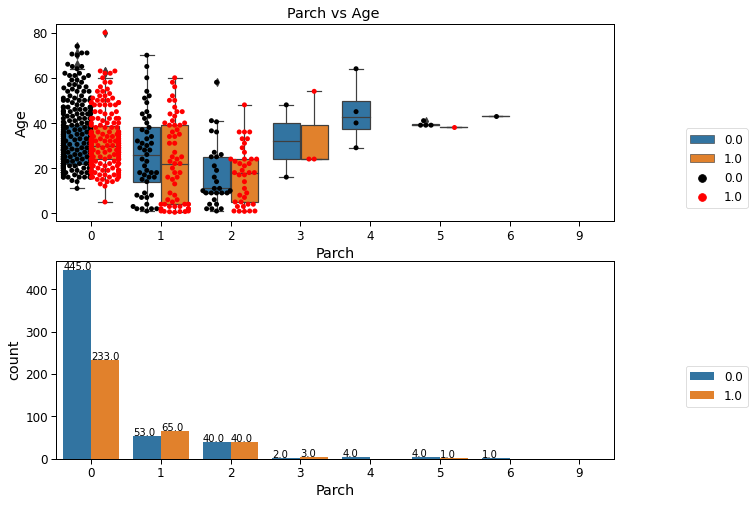

In [ ]:
plt.figure(figsize=(10,8))

ax=plt.subplot(2, 1, 1)
sns.boxplot(x='Parch',y='Age', hue='Survived', data=df)

sns.swarmplot(x='Parch', y='Age', hue='Survived', data=df, dodge=True,
             palette=sns.color_palette(['black', 'red']))
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Parch vs Age ')

ax=plt.subplot(2, 1, 2)
sns.countplot(x="Parch", hue="Survived", data=df)
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)

for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+1.5),fontsize=10 )
plt.show()

In [ ]:
display(df.pivot_table(index=['SibSp'], values='Survived', margins=False, 
        aggfunc=['mean', 'count']).sort_values(('mean', 'Survived'), ascending=False))


display(df.pivot_table(index=['Parch'], values='Survived', 
        aggfunc=['mean', 'count']).sort_values(('mean', 'Survived'), ascending=False))

,mean,count
,Survived,Survived
SibSp,,
1,0.535885,209
2,0.464286,28
0,0.345395,608
3,0.250000,16
4,0.166667,18
5,0.000000,5
8,0.000000,7


,mean,count
,Survived,Survived
Parch,,
3,0.600000,5
1,0.550847,118
2,0.500000,80
0,0.343658,678
5,0.200000,5
4,0.000000,4
6,0.000000,1
9,NaN,0


SibSp和Parch數量>4死亡率高

獨行的旅客信佔幾乎快7成的數量,生存率也頗低

## 新增Family欄位

In [ ]:
#新增一個Family欄位
df['Family']=df['SibSp']+df['Parch']

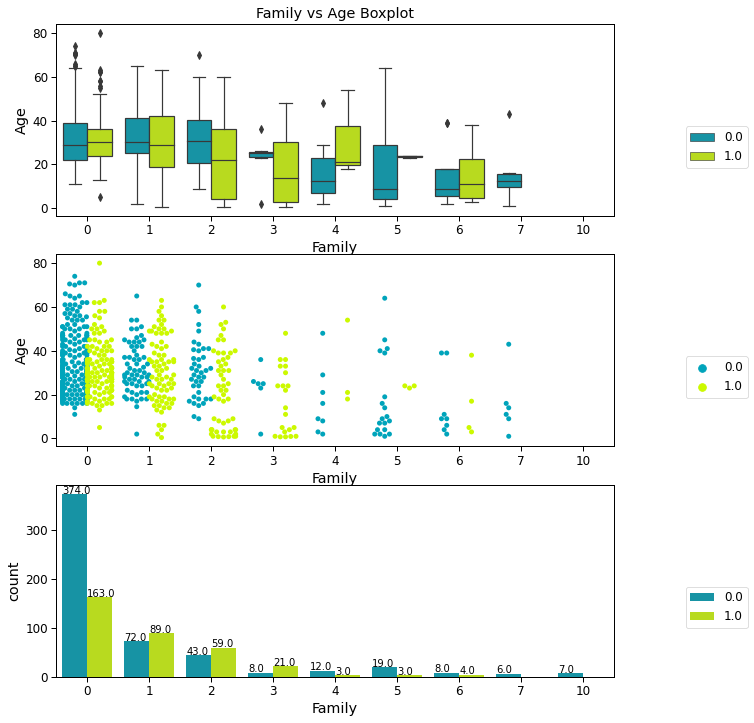

In [ ]:
plt.figure(figsize=(10,12))

ax=plt.subplot(3, 1, 1)
sns.boxplot(x='Family', y='Age', hue='Survived', data=df,palette='nipy_spectral')
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Family vs Age Boxplot')

ax=plt.subplot(3, 1, 2)
sns.swarmplot(x='Family', y='Age', hue='Survived', data=df, dodge=True,
             palette='nipy_spectral')
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)


ax=plt.subplot(3, 1, 3)
sns.countplot(x="Family", hue="Survived", data=df,palette='nipy_spectral')
ax.legend(loc='best', bbox_to_anchor=(1.25, 0.5), ncol=1)

for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+0.5),fontsize=10 )

plt.show()

In [ ]:
df.pivot_table(index=['Family'], values='Survived', margins=False, 
                  aggfunc=['mean', 'count']).sort_values(('mean', 'Survived'), ascending=False)

,mean,count
,Survived,Survived
Family,,
3,0.724138,29
2,0.578431,102
1,0.552795,161
6,0.333333,12
0,0.303538,537
4,0.200000,15
5,0.136364,22
7,0.000000,6


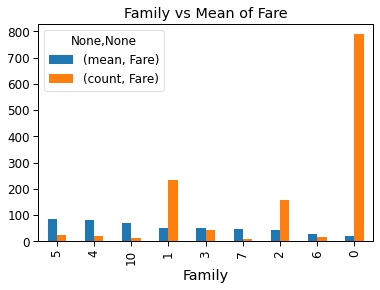

In [ ]:
df.pivot_table(index=['Family'], values='Fare', margins=False, 
                  aggfunc=['mean', 'count']).sort_values(('mean', 'Fare'), ascending=False).plot(kind='bar')
plt.title('Family vs Mean of Fare')
plt.show()

Family數量介於1~3個之間,生存率大於整體平均值0.38,

獨行的旅客因大多購買票價低的船票,故生存率也不高

# 特徵工程

In [5]:
#若由上而下執行,不需執行
path='/content/drive/MyDrive/Colab Notebooks/Titanic/'
train=pd.read_csv(path+'train.csv')
test=pd.read_csv(path+'test.csv')

#先合併,一起統一處理缺失值
df=pd.concat([train,test], ignore_index=True)
df.head()

#新增一個Family欄位,若由上而下執行,不需執行
df['Family']=df['SibSp']+df['Parch']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Family       1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


## Name
新增Title欄位

In [7]:
df['Title'] = df.Name.str.split(', ', expand=True)[1]
df['Title'] = df.Title.str.split('.', expand=True)[0]
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [9]:
df['Title'] = df.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Rare' )
df['Title'] = df.Title.replace( ['Ms','Mlle'], 'Miss' )
df['Title'] = df.Title.replace( 'Mme', 'Mrs' )
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'the Countess'],
      dtype=object)

## Sex

In [13]:
#看性別在Pclass的生存率
Survival_Rate = df[['Sex','Pclass','Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Sex,Pclass,Survival Rate(%)
0,female,1,96.808511
1,female,2,92.105263
2,female,3,50.000000
3,male,1,36.885246
4,male,2,15.740741
5,male,3,13.544669


In [14]:
#新增'Sex_Pclass' 欄位
#按照姓別vs艙等 給客人分類
#依據在不同艙等中的男女性生存率，給予不同的生存率級別(3最高、1最小)
df[ 'Sex_Pclass' ] = np.nan
df.loc[ (df.Sex=='female') & (df.Pclass==1), 'Sex_Pclass' ] = 3
df.loc[ (df.Sex=='female') & (df.Pclass==2), 'Sex_Pclass' ] = 3
df.loc[ (df.Sex=='female') & (df.Pclass==3), 'Sex_Pclass' ] = 2
df.loc[ (df.Sex=='male') & (df.Pclass==1), 'Sex_Pclass' ] = 2
df.loc[ (df.Sex=='male') & (df.Pclass==2), 'Sex_Pclass' ] = 1
df.loc[ (df.Sex=='male') & (df.Pclass==3), 'Sex_Pclass' ] = 1
df['Sex_Pclass'].unique()

array([1., 3., 2.])

## Age
填補遺漏值並新增Age_Range

In [15]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean = df[['Title','Age']].groupby( by=['Title'] ).mean()
Age_Median = df[['Title','Age']].groupby( by=['Title'] ).median()

Age_Mean.columns = ['Age Mean']
Age_Median.columns = ['Age Median']
Age_Mean.reset_index( inplace=True )
Age_Median.reset_index( inplace=True )

display( Age_Median )
display( Age_Mean )

,Title,Age Median
0,Master,4.0
1,Miss,22.0
2,Mr,29.0
3,Mrs,35.0
4,Rare,48.0
5,the Countess,33.0


,Title,Age Mean
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.629630
5,the Countess,33.000000


In [16]:
#利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df.loc[(df.Age.isnull())&(df.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][0]
df.loc[(df.Age.isnull())&(df.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][1]
df.loc[(df.Age.isnull())&(df.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][2]
df.loc[(df.Age.isnull())&(df.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][3]
df.loc[(df.Age.isnull())&(df.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][4]
df.loc[(df.Age.isnull())&(df.Title=='the Countess'),'Age'] = Age_Mean.loc[Age_Mean.Title=='the Countess','Age Mean'][5]

In [18]:
#將Age分區
df['Age_Range']=pd.qcut(df['Age'],4,labels=('0-21','21-30','30-36','36-80'))
df.groupby(['Age_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Age_Range,
0-21,0.454918
21-30,0.385366
30-36,0.288210
36-80,0.403756


<Figure size 360x360 with 0 Axes>

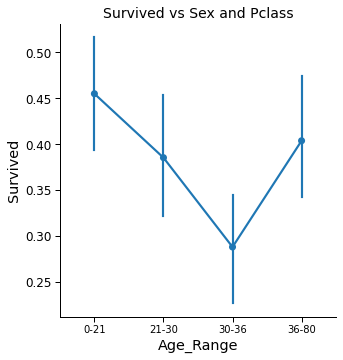

In [19]:
plt.figure(figsize=(5,5))
sns.set_context("paper",font_scale=1.5,rc={'xtick.labelsize': 10,'ytick.labelsize': 12,
'legend.fontsize': 12,'legend.title_fontsize': 12})

ax=sns.factorplot('Age_Range','Survived',data=df,size=5) 
plt.title('Survived vs Sex and Pclass', fontsize= 14)
plt.show()


In [20]:
# 對 Fare 欄位取對數,使其成類常態分配
df['Age'] = np.log1p( df.Age )

## Alone

In [21]:
#新增一個獨行旅客欄位
df.loc[(df.Family>0),'Alone']=0
df.loc[(df.Family<=0),'Alone']=1

## Ticket
新增Ticket_info欄立

In [22]:
df['Ticket_info'] = df.Ticket.apply( lambda x:x.replace('.','').replace('/','').strip().split(' ')[0] if not x.isdigit() else 'X')
df['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

## Fare

In [23]:
#Fare 缺失值填補
df.loc[df.Fare.isnull(),'Fare']=df[(df.Pclass==3)&(df.Family==0)&(df.Sex=='male')&(df.Age_Range=='36-80')].Fare.mean()

In [24]:
df['Fare_Range']=pd.qcut(df['Fare'],4,labels=('0-7.8','7.8-14.4','14.4-31.2','31.2-512.3'))
df.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
0-7.8,0.197309
7.8-14.4,0.303571
14.4-31.2,0.441048
31.2-512.3,0.600000


<Figure size 360x360 with 0 Axes>

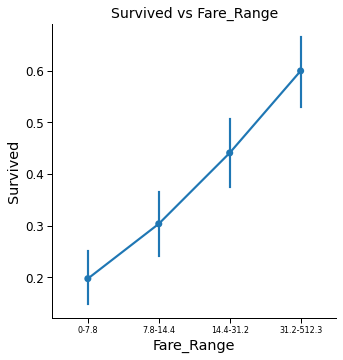

In [25]:
plt.figure(figsize=(5,5))
sns.set_context("paper",font_scale=1.5,rc={'xtick.labelsize': 8,'ytick.labelsize': 12,
'legend.fontsize': 12,'legend.title_fontsize': 12})

ax=sns.factorplot('Fare_Range','Survived',data=df,size=5) 
plt.title('Survived vs Fare_Range', fontsize= 14)
plt.show()


# 對 Fare 欄位取對數,使其成類常態分配
df['Fare'] = np.log1p( df.Fare )

## Cabin


In [26]:
#缺失值處理
# 取出 Cabin 中的第一個字母，如果為缺漏值，則以 NoCabin 表示
df['Cabin'] = df['Cabin'].apply( lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin' )

# 觀察 Cabin 中的種類
df['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

## Embarked

In [27]:
#Embarked缺失值 按數量最多的'S'來填補  
df['Embarked'][df.Embarked.isnull()]='S'

## 不需要的欄位drop

In [28]:
#PassengerId 完全不相關捨棄
#'Name','Ticket' 前面處理過了,不保留
df=df.drop(['PassengerId','Name','Ticket','SibSp','Parch'],axis=1)

In [29]:
#看一下處理結果,沒有缺失值了
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    float64 
 1   Pclass       1309 non-null   int64   
 2   Sex          1309 non-null   object  
 3   Age          1309 non-null   float64 
 4   Fare         1309 non-null   float64 
 5   Cabin        1309 non-null   object  
 6   Embarked     1309 non-null   object  
 7   Family       1309 non-null   int64   
 8   Title        1309 non-null   object  
 9   Sex_Pclass   1309 non-null   float64 
 10  Age_Range    1309 non-null   category
 11  Alone        1309 non-null   float64 
 12  Ticket_info  1309 non-null   object  
 13  Fare_Range   1309 non-null   category
dtypes: category(2), float64(5), int64(2), object(5)
memory usage: 125.8+ KB


## 分割train,test

In [30]:
train=df[~df['Survived'].isnull()]
test=df[df['Survived'].isnull()]
test=test.drop('Survived',axis=1)

# 編碼處理

## Train編碼處理


In [31]:
#先copy一份要處理的欄位
train['Sex_woe']=train['Sex']
train['Cabin_woe']=train['Cabin']
train['Embarked_woe']=train['Embarked']
train['Title_woe']=train['Title']
train['Age_Range_woe']=train['Age_Range']
train['Ticket_info_woe']=train['Ticket_info']
train['Fare_Range_woe']=train['Fare_Range']

In [ ]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Family,Title,Sex_Pclass,...,Alone,Ticket_info,Fare_Range,Sex_woe,Cabin_woe,Embarked_woe,Title_woe,Age_Range_woe,Ticket_info_woe,Fare_Range_woe
0,0.0,3,male,3.135494,2.110213,NoCabin,S,1,Mr,1.0,...,0.0,A5,0-7.8,male,NoCabin,S,Mr,21-30,A5,0-7.8
1,1.0,1,female,3.663562,4.280593,C,C,1,Mrs,3.0,...,0.0,PC,31.2-512.3,female,C,C,Mrs,36-80,PC,31.2-512.3
2,1.0,3,female,3.295837,2.188856,NoCabin,S,0,Miss,2.0,...,1.0,STONO2,7.8-14.4,female,NoCabin,S,Miss,21-30,STONO2,7.8-14.4
3,1.0,1,female,3.583519,3.990834,C,S,1,Mrs,3.0,...,0.0,X,31.2-512.3,female,C,S,Mrs,30-36,X,31.2-512.3
4,0.0,3,male,3.583519,2.202765,NoCabin,S,0,Mr,1.0,...,1.0,X,7.8-14.4,male,NoCabin,S,Mr,30-36,X,7.8-14.4


In [32]:
'''
有測試使用onehotcodeing有測試雖準確度沒有提高,但維度增加太多,故改用woeencoder算資料權重,適用結果為1/0的模型判斷

還有很多編碼方式,可參考:
https://cloud.tencent.com/developer/article/1764822

要使用WOEEncoder 需要安裝  => !pip install category-encoders

'''


def woeencoder(X,y):
    woe = ce.WOEEncoder(cols=X.name, random_state=42)
    encoded_df=woe.fit_transform(X, y)
    return encoded_df

#不同Cabin的生存率平均值和數量
display(train.pivot_table(index=['Cabin'], values='Survived', margins=False, aggfunc=
                  ['mean', 'count'],sort=True).sort_values(('mean', 'Survived'), ascending=False))
print('----------------------------------------------')
#不同Title的生存率平均值和數量
display(train.pivot_table(index=['Title'], values='Survived', margins=False, aggfunc=
                  ['mean', 'count'],sort=True).sort_values(('mean', 'Survived'), ascending=False))
print('----------------------------------------------')
#不同Ticket_info的生存率平均值和數量
display(train.pivot_table(index=['Ticket_info'], values='Survived', margins=False, aggfunc=
                  ['mean', 'count'],sort=True).sort_values(('mean', 'Survived'), ascending=True))


#採用權重編碼
train['Sex_woe']=woeencoder(train['Sex'],train['Survived'])
train['Cabin_woe']=woeencoder(train['Cabin'],train['Survived'])
train['Embarked_woe']=woeencoder(train['Embarked'],train['Survived'])
train['Title_woe']=woeencoder(train['Title'],train['Survived'])
train['Age_Range_woe']=woeencoder(train['Age_Range'],train['Survived'])
train['Ticket_info_woe']=woeencoder(train['Ticket_info'],train['Survived'])
train['Fare_Range_woe']=woeencoder(train['Fare_Range'],train['Survived'])

,mean,count
,Survived,Survived
Cabin,,
D,0.757576,33
E,0.750000,32
B,0.744681,47
F,0.615385,13
C,0.593220,59
G,0.500000,4
A,0.466667,15
NoCabin,0.299854,687


----------------------------------------------


,mean,count
,Survived,Survived
Title,,
the Countess,1.000000,1
Mrs,0.793651,126
Miss,0.702703,185
Master,0.575000,40
Rare,0.318182,22
Mr,0.156673,517


----------------------------------------------


,mean,count
,Survived,Survived
Ticket_info,,
A4,0.000000,7
SCA4,0.000000,1
SOP,0.000000,1
SOPP,0.000000,3
SOTONO2,0.000000,2
SCOW,0.000000,1
SP,0.000000,1
Fa,0.000000,1


## Test資料編碼

In [33]:
#看下train轉換後的權重值
#train.pivot_table(index=['Sex'], values='Sex_woe')
#train.pivot_table(index=['Cabin'], values='Cabin_woe')
#train.pivot_table(index=['Embarked'], values='Embarked_woe')
#train.pivot_table(index=['Title'], values='Title_woe')
#train.pivot_table(index=['Ticket_info'], values='Ticket_info_woe')
#train.pivot_table(index=['Fare_Range'], values='Fare_Range_woe')
train.pivot_table(index=['Age_Range'], values='Age_Range_woe')

,Age_Range_woe
Age_Range,
0-21,0.291752
21-30,0.008933
30-36,-0.424081
36-80,0.084971


In [34]:
#要對映到test資料
Sex_woe_map={'female':1.519695,'male':-0.979029}
Cabin_woe_map={'A':0.353310,'B':1.489663,'C':0.835736,'D':1.531965,
        'E':1.492744,'F':0.876558,'G':0.471093,'NoCabin':-0.374132,'T':0.000000}
Embarked_woe_map={'C':0.683655,'Q':0.033879,'S':-0.194402}  
Title_woe_map={'Master':0.758775,'Miss':1.320939,'Mr':-1.202121,'Mrs':1.790377,'Rare':-0.222054,'the Countess':	0.000000} 
Ticket_info_woe_map={'A4':-1.608348,'A5':-1.426027,'AS':0.000000,'C':0.183411,'CA':-0.153061,'CASOTON':0.000000,'FC':0.000000,
        'FCC':1.387384,'Fa':0.000000,'LINE':-0.222054,'PC':1.068930,'PP':0.876558,'PPP':0.471093,'SC':0.000000,
        'SCA4':0.000000,'SCAH':0.876558,'SCOW':0.000000,'SCPARIS':0.247950,'SCParis':0.471093,'SOC':-0.627519,
        'SOP':0.000000,'SOPP':-0.915201,'SOTONO2':-0.627519,'SOTONOQ':-1.069352,'SP':0.000000,'STONO':0.183411,
         'STONO2':0.471093,'SWPP':1.569705,'WC':-1.138345,'WEP':0.065628,'X':0.001090,
         'A':0,'AQ3':0,'AQ4':0,'LP':0,'SCA3':0,'STONOQ':0} #這一行只有test資料才有

Fare_Range_woe_map={'0-7.8':-0.915201,'7.8-14.4':-0.351046,'14.4-31.2':0.236254,'31.2-512.3':0.872719} 
Age_Range_woe_map={'0-21':0.291752,'21-30':0.008933,'30-36':-0.424081,'36-80':0.084971} 


#先copy一份要處理的欄位
test['Sex_woe']=test['Sex']
test['Cabin_woe']=test['Cabin']
test['Embarked_woe']=test['Embarked']
test['Title_woe']=test['Title']
test['Age_Range_woe']=test['Age_Range']
test['Ticket_info_woe']=test['Ticket_info']
test['Fare_Range_woe']=test['Fare_Range']


test.Sex_woe=test.Sex.map(Sex_woe_map)
test.Cabin_woe=test.Cabin.map(Cabin_woe_map)
test.Embarked_woe=test.Embarked.map(Embarked_woe_map)
test.Title_woe=test.Title.map(Title_woe_map)
test.Ticket_info_woe=test.Ticket_info.map(Ticket_info_woe_map)
test.Fare_Range_woe=test.Fare_Range.map(Fare_Range_woe_map)
test.Age_Range_woe=test.Age_Range.map(Age_Range_woe_map)

In [306]:
test.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family,Title,Sex_Pclass,Age_Range,Alone,Ticket_info,Fare_Range,Sex_woe,Cabin_woe,Embarked_woe,Title_woe,Age_Range_woe,Ticket_info_woe,Fare_Range_woe
891,3,male,3.569533,2.178064,NoCabin,Q,0,Mr,1.0,30-36,1.0,X,0-7.8,-0.979029,-0.374132,0.033879,-1.202121,-0.424081,0.00109,-0.915201
892,3,female,3.871201,2.079442,NoCabin,S,1,Mrs,2.0,36-80,0.0,X,0-7.8,1.519695,-0.374132,-0.194402,1.790377,0.084971,0.00109,-0.915201
893,2,male,4.143135,2.369075,NoCabin,Q,0,Mr,1.0,36-80,1.0,X,7.8-14.4,-0.979029,-0.374132,0.033879,-1.202121,0.084971,0.00109,-0.351046
894,3,male,3.332205,2.268252,NoCabin,S,0,Mr,1.0,21-30,1.0,X,7.8-14.4,-0.979029,-0.374132,-0.194402,-1.202121,0.008933,0.00109,-0.351046
895,3,female,3.135494,2.586824,NoCabin,S,2,Mrs,2.0,21-30,0.0,X,7.8-14.4,1.519695,-0.374132,-0.194402,1.790377,0.008933,0.00109,-0.351046


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Pclass           418 non-null    int64   
 1   Sex              418 non-null    object  
 2   Age              418 non-null    float64 
 3   Fare             418 non-null    float64 
 4   Cabin            418 non-null    object  
 5   Embarked         418 non-null    object  
 6   Family           418 non-null    int64   
 7   Title            418 non-null    object  
 8   Sex_Pclass       418 non-null    float64 
 9   Age_Range        418 non-null    category
 10  Alone            418 non-null    float64 
 11  Ticket_info      418 non-null    object  
 12  Fare_Range       418 non-null    category
 13  Sex_woe          418 non-null    float64 
 14  Cabin_woe        418 non-null    float64 
 15  Embarked_woe     418 non-null    float64 
 16  Title_woe        418 non-null    float64 

In [36]:
#train,test原始的資料捨棄
train=train.drop(['Sex','Cabin','Embarked','Title','Ticket_info','Fare_Range','Age_Range'],axis=1)
test=test.drop(['Sex','Cabin','Embarked','Title','Ticket_info','Fare_Range','Age_Range'],axis=1)

# 機器學習

In [37]:
def draw_report(y_test,y_pred):
    # 畫圖
    conf_matrix= confusion_matrix(y_test,y_pred)

    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.show()
    print("")
    print(classification_report(y_test, y_pred))

##分割X_train, X_test, y_train, y_test

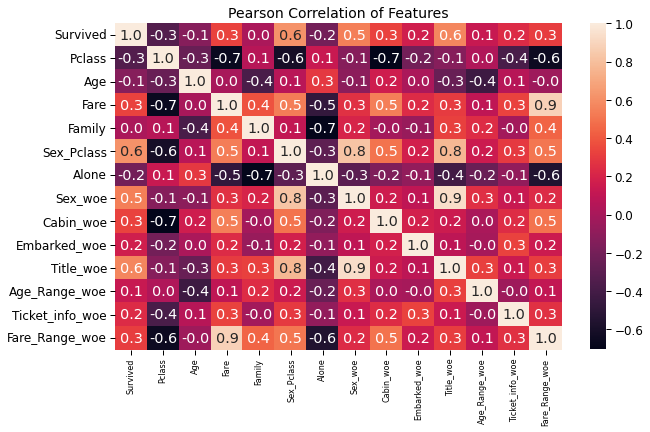

In [38]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(),annot=True,fmt=".1f")
plt.title('Pearson Correlation of Features', y=1.05, size=14)
plt.show()

In [39]:
#分割資料
y=train['Survived']
X=train.drop('Survived',axis=1)


from sklearn.model_selection import train_test_split
#stratify=y 使惡性資料按比例分配在測試集和訓練集中,可避免分配不均
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

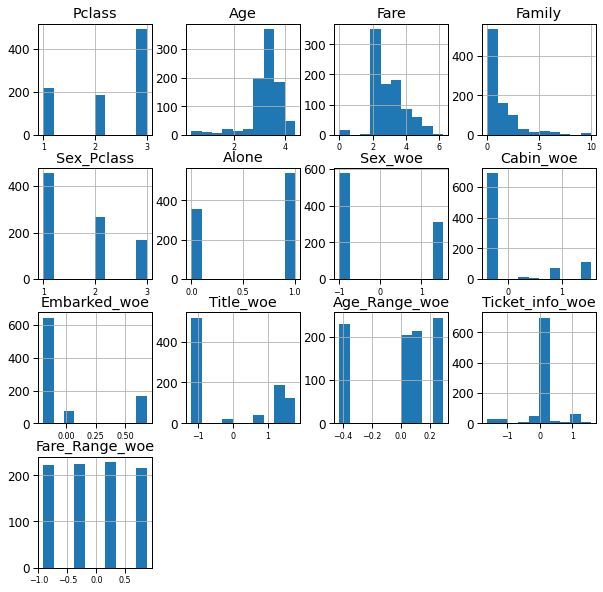

In [40]:
#分佈結果
X.hist(figsize=(10,10))
plt.show()

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           891 non-null    int64  
 1   Age              891 non-null    float64
 2   Fare             891 non-null    float64
 3   Family           891 non-null    int64  
 4   Sex_Pclass       891 non-null    float64
 5   Alone            891 non-null    float64
 6   Sex_woe          891 non-null    float64
 7   Cabin_woe        891 non-null    float64
 8   Embarked_woe     891 non-null    float64
 9   Title_woe        891 non-null    float64
 10  Age_Range_woe    891 non-null    float64
 11  Ticket_info_woe  891 non-null    float64
 12  Fare_Range_woe   891 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 129.7 KB


## XGBClassifier

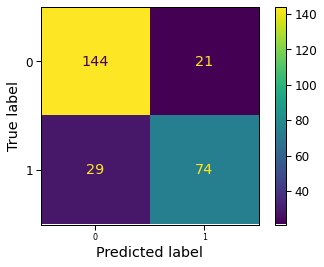


              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       165
         1.0       0.78      0.72      0.75       103

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



In [42]:
from xgboost import XGBClassifier 
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred= xgb.predict(X_test)

draw_report(y_test,y_pred)

## RandomForestClassifier

,Feature_Name,Importance
9,Title_woe,0.189707
4,Sex_Pclass,0.186076
6,Sex_woe,0.156931
2,Fare,0.100947
1,Age,0.081610
7,Cabin_woe,0.072723
0,Pclass,0.047172
11,Ticket_info_woe,0.043311
3,Family,0.042285
12,Fare_Range_woe,0.034078


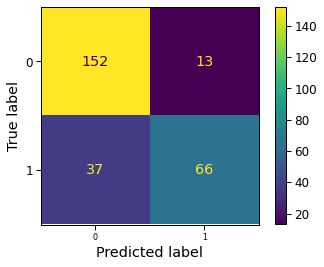


              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86       165
         1.0       0.84      0.64      0.73       103

    accuracy                           0.81       268
   macro avg       0.82      0.78      0.79       268
weighted avg       0.82      0.81      0.81       268



In [43]:
from sklearn.ensemble import RandomForestClassifier
# 建立決策樹模型
DTC = RandomForestClassifier( n_estimators = 1000,
                min_samples_split = 20,
                min_samples_leaf = 1,
                oob_score = True,
                random_state = 1,
                n_jobs = -1 ) 


# 自變數、應變數進行擬合
DTC.fit( X_train, y_train )

# 排序特徵重要性(由大到小)
col_names = X_train.columns
importances = DTC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True ) 
display(Feature_Rank)

y_pred= DTC.predict(X_test)

print()
draw_report(y_test,y_pred)

In [44]:
print( 'oob_score = {:.6f}'.format(DTC.oob_score_) )

oob_score = 0.825040


## LogisticRegression

訓練準確度 0.8362760834670947


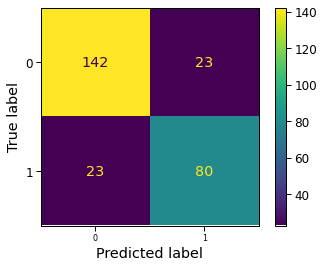


              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86       165
         1.0       0.78      0.78      0.78       103

    accuracy                           0.83       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268



In [45]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression().fit(X_train, y_train)

print("訓練準確度",reg.score(X_train, y_train))
y_pred= reg.predict(X_test)
draw_report(y_test,y_pred)

In [47]:
sub=reg.predict(test)
sub

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

## Autosklearn
Autosklearn執行後,很常出現版本不符錯誤,看訊息是什麼再做處理,以下步驟跑完,2022/5/10當下是可以跑的

### 要安裝的檔案

In [317]:
#1
!pip install auto-sklearn
#2
!pip install -U scikit-learn
#3
!pip install scikit-learn==0.24.0

     |████████████████████████████████| 6.4 MB 4.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 52.2 MB/s 
     |████████████████████████████████| 837 kB 48.8 MB/s 
     |████████████████████████████████| 4.3 MB 43.9 MB/s 
     |████████████████████████████████| 4.0 MB 19.8 MB/s 
     |████████████████████████████████| 260 kB 49.4 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
     |████████████████████████████████| 136 kB 65.3 MB/s 
     |████████████████████████████████| 46 kB 2.4 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.7-py3-none-any.whl size=6602873 sha256=3318c804d1f677aba28ee16767785c05b055f0c9d44cf46a5bf4f5ac714d9f8d
  Stored in directory: /root/.cache/pip/wheels/ba/43/5c/2fbe6fd19e3af314cbc4aa808378068d8ddd6792064f4a2448
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7043 sha256=33c2f

     |████████████████████████████████| 24.8 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auto-sklearn 0.14.7 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.0.2 which is incompatible.


     |████████████████████████████████| 22.3 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.0 which is incompatible.


In [48]:
import sklearn
print(sklearn.__version__)

0.24.0


In [ ]:
#4
!pip uninstall scipy
!pip install scipy==1.7.3

Found existing installation: scipy 1.7.3
Uninstalling scipy-1.7.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scipy-1.7.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scipy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.7/dist-packages/scipy.libs/libopenblasp-r0-2d23e62b.3.17.so
    /usr/local/lib/python3.7/dist-packages/scipy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.7/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.7.3
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.0 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
albumentations 

###版本一

In [49]:
import autosklearn.classification

automlclassifierV1 = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=180, #採索每個模型限制時間,單位秒
    per_run_time_limit=40, #機器模型訓練時間
    resampling_strategy='cv', #處理過擬合方法,使用交叉驗証,
    resampling_strategy_arguments={'folds': 5}
)
automlclassifierV1.fit(X_train, y_train)

AutoSklearnClassifier(per_run_time_limit=40, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 5},
                      time_left_for_this_task=180)

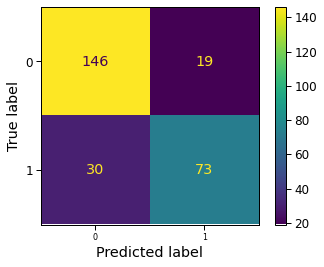


              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       165
         1.0       0.79      0.71      0.75       103

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.81       268



In [51]:
y_pred= automlclassifierV1.predict(X_test)

#畫圖
draw_report(y_test,y_pred)

In [52]:
pred_V1= automlclassifierV1.predict(test)
pred_V1

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0.

In [53]:
#auto sklearn權重排行
automlclassifierV1.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
4,1,0.16,extra_trees,0.149278,15.012851
6,2,0.12,random_forest,0.158909,11.193073
2,3,0.30,random_forest,0.160514,8.882659
3,4,0.20,extra_trees,0.165329,20.082531
11,5,0.04,gradient_boosting,0.173355,12.156258
7,6,0.08,mlp,0.182986,7.726977
8,7,0.04,gradient_boosting,0.194222,13.842025
9,8,0.06,random_forest,0.208668,10.536964


### 版本二

In [54]:
#版本二 auto sklearn最新版本
from autosklearn.experimental.askl2 import AutoSklearn2Classifier

automlclassifierV2 = AutoSklearn2Classifier(time_left_for_this_task=180, per_run_time_limit=40)
automlclassifierV2.fit(X_train, y_train)

AutoSklearn2Classifier(metric=accuracy, per_run_time_limit=40,
                       time_left_for_this_task=180)

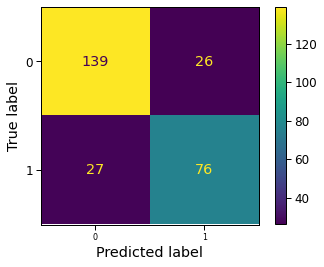


              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       165
         1.0       0.75      0.74      0.74       103

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



In [55]:
y_pred= automlclassifierV2.predict(X_test)

#畫圖
draw_report(y_test,y_pred)

In [ ]:
pred_V2= automlclassifierV2.predict(test)
pred_V2

array([0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [ ]:
automlclassifierV2.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,0.02,extra_trees,0.162119,7.567837
8,2,0.04,extra_trees,0.176565,7.753418
7,3,0.02,mlp,0.186196,7.965369
4,4,0.02,sgd,0.215088,7.290974
9,5,0.90,sgd,0.261637,6.233187


In [ ]:
#參數結果
automlclassifierV2.cv_results_['params']

[{'balancing:strategy': 'weighting',
  'classifier:__choice__': 'extra_trees',
  'classifier:extra_trees:bootstrap': 'False',
  'classifier:extra_trees:criterion': 'entropy',
  'classifier:extra_trees:max_depth': 'None',
  'classifier:extra_trees:max_features': 0.9565902080710877,
  'classifier:extra_trees:max_leaf_nodes': 'None',
  'classifier:extra_trees:min_impurity_decrease': 0.0,
  'classifier:extra_trees:min_samples_leaf': 4,
  'classifier:extra_trees:min_samples_split': 15,
  'classifier:extra_trees:min_weight_fraction_leaf': 0.0,
  'data_preprocessor:__choice__': 'feature_type',
  'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
  'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
  'data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.11840768063684459,
  'data_preprocessor:feature_type:numerical_tra

# 超參數挑選

### RandomizedSearchCV

In [56]:
#LogisticRegression 的超參數挑選
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import scipy


tuned_parameters={'C':scipy.stats.expon(scale=100),
        'multi_class':['ovr','multinomial'],
        'penalty':['none', 'l1', 'l2', 'elasticnet'],
        'solver':['lbfgs','newton-cg','sag','liblinear']
        }

clf=RandomizedSearchCV(LogisticRegression(tol=1e-60),tuned_parameters,cv=10,scoring='accuracy',n_iter=100)
 
#clf=RandomizedSearchCV(LogisticRegression(penalty='l2',solver='lbfgs',tol=1e-6),tuned_parameters,cv=10,scoring='accuracy',n_iter=100)



clf.fit(X_train,y_train)
best_param_random=clf.best_params_

print('best parameters:',clf.best_estimator_)
print('Best Hyperparameters: %s' % clf.best_params_)
print()
print(classification_report(y_test,clf.predict(X_test)))
print(confusion_matrix(y_test,clf.predict(X_test)))

best parameters: LogisticRegression(C=122.34824668729456, multi_class='ovr', tol=1e-60)
Best Hyperparameters: {'C': 122.34824668729456, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}

              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       165
         1.0       0.77      0.80      0.78       103

    accuracy                           0.83       268
   macro avg       0.82      0.83      0.82       268
weighted avg       0.83      0.83      0.83       268

[[141  24]
 [ 21  82]]


In [59]:
sub_random=clf.predict(test)
sub_random

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

### GridSearchCV

In [60]:
#縮小'C'的範圍再跑GridSearchCV
from sklearn.model_selection import GridSearchCV

tuned_parameters={'C':[1,10,36,100,120],
        'multi_class':['ovr','multinomial'],
        'penalty':['none', 'l1', 'l2', 'elasticnet'],
        'solver':['lbfgs','newton-cg','sag','liblinear']
        }


# define search
GridSearchCV(clf, tuned_parameters, scoring='accuracy', n_jobs=-1, cv=10)
# execute search
clf.fit(X_train,y_train)
best_param_grid=clf.best_params_
# summarize result
print('Best Score: %s' % clf.best_score_)
print('Best Hyperparameters: %s' % clf.best_params_)

Best Score: 0.8218894009216591
Best Hyperparameters: {'C': 61.029827092425, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'newton-cg'}


# 特徵選擇

In [61]:
from sklearn.linear_model import LogisticRegression

# RandomizedSearchCV的參數
reg = LogisticRegression(
    tol=1e-6,
    C=best_param_random['C'],
    multi_class=best_param_random['multi_class'],
    penalty=best_param_random['penalty'],
    solver=best_param_random['solver'],
    max_iter=100)

In [ ]:
# GridSearchCV的參數
reg = LogisticRegression(
    tol=1e-6,
    C=best_param_grid['C'],
    multi_class=best_param_grid['multi_class'],
    penalty=best_param_grid['penalty'],
    solver=best_param_grid['solver'],
    max_iter=100)

## 使用RFECV

In [62]:
from sklearn.feature_selection import RFECV
rfecv=RFECV(estimator=reg,step=1,cv=10,scoring='accuracy')
#since it uses cross validation, we should fit it to the whole dataset
rfecv.fit(X_train,y_train)

RFECV(cv=10,
      estimator=LogisticRegression(C=122.34824668729456, multi_class='ovr',
                                   tol=1e-06),
      scoring='accuracy')

In [63]:
print("N_features %s" % rfecv.n_features_)
print()
print("Support is %s" % rfecv.support_)
print()
print("Ranking %s" % rfecv.ranking_)
print()
print("Grid Scores %s" % rfecv.grid_scores_)
print()
#to get feature names
RFECV_list=list(X_train.columns[rfecv.support_])
print("feature names:",RFECV_list)

N_features 13

Support is [ True  True  True  True  True  True  True  True  True  True  True  True
  True]

Ranking [1 1 1 1 1 1 1 1 1 1 1 1 1]

Grid Scores [0.75765489 0.81059908 0.80430108 0.79943676 0.80588838 0.81226318
 0.81387609 0.81546339 0.81543779 0.81543779 0.81866359 0.8202765
 0.8218894 ]

feature names: ['Pclass', 'Age', 'Fare', 'Family', 'Sex_Pclass', 'Alone', 'Sex_woe', 'Cabin_woe', 'Embarked_woe', 'Title_woe', 'Age_Range_woe', 'Ticket_info_woe', 'Fare_Range_woe']


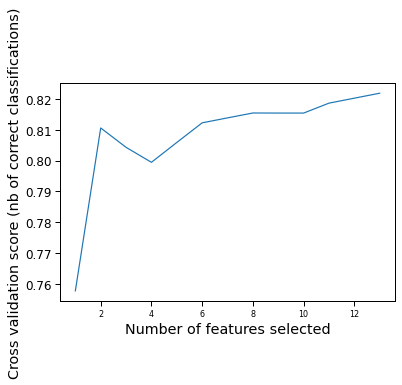

In [64]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

訓練準確率: 0.8362760834670947


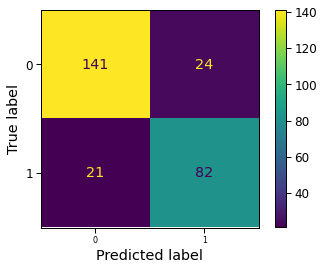


              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       165
         1.0       0.77      0.80      0.78       103

    accuracy                           0.83       268
   macro avg       0.82      0.83      0.82       268
weighted avg       0.83      0.83      0.83       268



In [65]:
reg.fit(X_train[RFECV_list], y_train)

print('訓練準確率:',reg.score(X_train[RFECV_list], y_train))


#測試集結果
y_pred= reg.predict(X_test[RFECV_list])
draw_report(y_test,y_pred)

## 使用LinearSVC

In [66]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)
X_new.shape

(623, 5)

In [67]:
line_svc=model.get_support()

#看下選中的特徵
display(line_svc)
display(line_svc.shape)

array([ True, False, False,  True,  True, False, False,  True, False,
        True, False, False, False])

(13,)

In [68]:
model.transform(X_train.values)

array([[ 1.        ,  1.        ,  2.        ,  1.53196511, -1.2021208 ],
       [ 3.        ,  0.        ,  1.        , -0.37413217, -1.2021208 ],
       [ 3.        ,  0.        ,  2.        , -0.37413217,  1.32093878],
       ...,
       [ 3.        ,  4.        ,  2.        , -0.37413217,  1.7903768 ],
       [ 1.        ,  0.        ,  2.        ,  1.4927444 , -1.2021208 ],
       [ 1.        ,  2.        ,  3.        ,  1.53196511,  1.32093878]])

In [70]:
LinearSVC_list=list(X_train.columns[line_svc])
LinearSVC_list
#篩選新的特徵下去跑機器學習

['Pclass', 'Family', 'Sex_Pclass', 'Cabin_woe', 'Title_woe']

訓練準確率: 0.8170144462279294


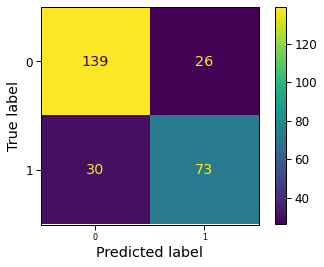


              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       165
         1.0       0.74      0.71      0.72       103

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268



In [71]:
reg.fit(X_train[LinearSVC_list], y_train)
print('訓練準確率:',reg.score(X_train[LinearSVC_list], y_train))


#測試集結果
y_pred= reg.predict(X_test[LinearSVC_list])
draw_report(y_test,y_pred)

# 結論

In [ ]:
#結論:

#選用特徵13個: 
#'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Family', 
#'Title', 'Sex_Pclass', 'Age_Range', 'Alone', 'Ticket_info', 'Fare_Range'

#特徵處理:
#'Pclass':無需處理

#'Sex':
#1.新增Sex_Pclass欄位,依據在不同艙等中的男女性生存率，給予不同的生存率級別(3最高、1最小),
#2.'Sex'作權重編碼

#'Age':
#1.利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值,
#2.有新增Age_Range，測試過後，應可捨棄'Age',測試後模型效果不好,故保留
#3.Age作常態化處理,
#4.Age,Age_Range作權重編碼

#'Fare':
#1.新增'Fare_Range'欄位,應可捨棄'Fare',測試後模型效果不好,故保留。
#2.Fare因有離群值,作常態化處理
#3.Fare_Range作權重編碼


#'Cabin':作權重編碼

#'Embarked':作權重編碼

#新增'Family':'SibSp'+'Parch'

#'Title':
#1.由Name而來,分為'Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'the Countess'
#2.作權重編碼

#'Sex_Pclass:同'Sex'步驟

#Age_Range:同'Age'步驟

#'Alone':新增是否獨行欄位

#'Ticket_info':由Ticket處理而來,作權重編碼

#'Fare_Range':同'Fare'步驟


#模型選用:
#使用LogisticRegression()

#超參數:
# C=162.6536408785796,multi_class='multinomial', penalty='none',solver='newton-cg', tol=1e-06


#其模型準確率約84%



## LogisticRegression

0.8362760834670947


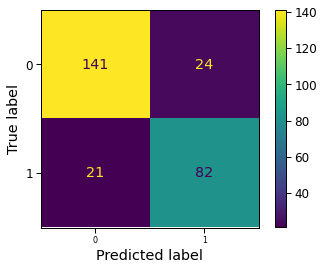


              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       165
         1.0       0.77      0.80      0.78       103

    accuracy                           0.83       268
   macro avg       0.82      0.83      0.82       268
weighted avg       0.83      0.83      0.83       268



In [74]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(
    C=162.6536408785796,multi_class='multinomial', penalty='none',solver='newton-cg', tol=1e-06).fit(X_train, y_train)

print(reg.score(X_train, y_train))
y_pred= reg.predict(X_test)
draw_report(y_test,y_pred)

In [75]:
sub_3= reg.predict(test)
sub_3

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

# Kaggle submission step

In [76]:
#觀察資料型態
submission =pd.read_csv(path+'gender_submission.csv')
display(submission.head())
display('-----------------------------------------')
display(submission.info())

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


'-----------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


None

In [77]:
submission['Survived']=sub
submission['Survived']=submission['Survived'].astype('int')
submission.to_csv('submission_file.csv',index=False)


#上傳後最佳成績得到了Score: 0.77272,
#看到有人是100分?太神奇了,要繼續努力!!

In [ ]:
#參考連結
#https://aifreeblog.herokuapp.com/posts/64/Data_Analytics_in_Practice_Titanic/
#https://medium.com/%E6%95%B8%E6%93%9A%E4%B8%8D%E6%AD%A2-not-only-data/pandas-%E5%BF%AB%E9%80%9F%E7%9E%AD%E8%A7%A3-pivot-table-%E8%88%87%E6%87%89%E7%94%A8-21e4c37b9216